# App Coverage & Compliance Sensitivity Analysis

### Description: 

This notebook walks through the steps to perform sensitivity analysis (SA) on TTI to determine higher order interactions of the variables App Coverage and Compliance. 

App Coverage: Percentage of people who use the NHS app to track people they may have been in contact with.

Compliance:   Percentage of people who copmly with the quarantine guidelines.

### Motivation:

The reason we run this experiment is to determine whether there actually exist higher order interactions between app usage and compliance. We focus on those two variables as they were the ones mostly explored in the TTI techincal report. The technical report inncludes SA only by changing the values over a grid/axis and did not examine the possibility of higher order interactions.

### Notes:

Following the TTI techincal report we perform experiments on symptom based TTI (e.g. see page 22 of techincal report) for strigency levels S1-S5. We focus onn symptom based as it seems to be the most effective. Due to limited computation we cannot run experiments for all TTI strategies. 

Using Integrated Variance Reduction takes a significant amount of time.

### Parameters Set Ups/Assumptions:
We assume that at least 5% of people can will use the app and this can increase up to 99%, i.e. almost. everyone.
We also assume that at least 20% of people will comply and this can increase for up to 95%.

### Results
There doesn't seem to be any significant higher order interaction between app usage and compliance. Apparently, compliance seems to be the dominant variable in controlling effective R. This is to be expected, as alreadyby observing the Figure on  page 22 of the TTI techincal report we can note that compliance is significantly more effective in reducing the reproduction number compared to app update. This can also be observed from the function plot over AU and C, where the function varies significanlty more based on the compliance percentage, The reason is that tracing can occur manually in the first place, hence, tracking can still occur and high\low compliance becomes the central factor in affecting R.


In [80]:
import os
import numpy as np
import pandas as pd
from   tqdm.notebook import trange
from   tti_explorer import config, utils
from   tti_explorer.case import simulate_case, CaseFactors
from   tti_explorer.contacts import EmpiricalContactsSimulator
from   tti_explorer.strategies import TTIFlowModel, RETURN_KEYS
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

from   matplotlib import colors as mcolors
from   matplotlib import cm
import numpy as np
import GPy
from   emukit.core import ContinuousParameter, ParameterSpace

from emukit_new.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
from emukit_new.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit_new.sensitivity.monte_carlo import MonteCarloSecondOrderSensitivity

from   emukit.core.initial_designs import RandomDesign
from   GPy.models import GPRegression
from   emukit.model_wrappers import GPyModelWrapper

from   emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from   emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai
import pandas as pd
from   tti_explorer.strategies import TTIFlowModel

#SALib Sobol
from SALib.sample import saltelli
from SALib.analyze import sobol
import time 

def print_doc(func):
    print(func.__doc__)
rng = np.random.RandomState(0)

def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")
path_to_bbc_data = os.path.join("../../data", "bbc-pandemic")


#     contacts_config['work_sar']=work_sar
def update_policy_config(app_uptake, pol_compl):
    policy_config['app_cov'] = app_uptake
    policy_config['compliance'] = pol_compl
    return policy_config

# policy_config = update_policy_config(0.5, 0.05)
# Separating this because it is built from the ammended policy_config


In [105]:

"""
Runs TTI simulator as many times as the different input initialisations.
The main reason we need this is to put in to EmuKit for the Experimental
Design Loop.

Args:
    pol_configs (list): Inputs are [app_cov, compliance]

Returns:
    effective_rs (np.expand_dims(np.array(to_return), 1)): For every simulation run, return
    the effective r, as was plotted form Bryn and Andrei previously.

"""
#simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)


def run_tti_sim(pol_configs):
    to_return=[]
    for vals in pol_configs:
        policy_config = update_policy_config(vals[0], vals[1])
        factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
        strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
        rng = np.random.RandomState(42)
#         strategy_config['do_manual_tracing']  = False
#         strategy_config['manual_trace_delay'] = 5
#         strategy_config['manual_home_trace_prob'] = int(0)
#         strategy_config['manual_work_trace_prob'] = int(0)
#         strategy_config['manual_othr_trace_prob'] = int(0)

        tti_model = TTIFlowModel(rng, **strategy_config)
        n_cases = 10000
        outputs = list()
        temp =[]
        for _ in trange(n_cases):
            case = simulate_case(rng, **case_config)
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            contacts = simulate_contacts(case, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            if res["Effective R"] >= 0:
                temp.append(res["Effective R"]) # Get effective R. Only non-nan vals are kept
        to_return.append(np.mean(temp))
    return np.expand_dims(np.array(to_return), 1)
v1 = [0.05, .99]
v2 = [0.2,.80]

# v6 = [0.05, .4]

In [109]:

def run_sensitivity(strigency, initial_samples, bo_samples, mc_samples, col):

    space = ParameterSpace([ContinuousParameter('app_cov', *v1),ContinuousParameter('compliance', *v2)]) # init param space for experimental design
    design = RandomDesign(space)
    x = design.get_samples(initial_samples) # get 5 random combinations of initialisations
    y = run_tti_sim(x) # obtain corresponding effective_rs

    # Fitting emulator to data, x: (app_cov, compliance), y: effective_r
    kern_eq = GPy.kern.RBF(input_dim=2, ARD = True) + GPy.kern.White(input_dim=2, variance=1)
    kern_bias = GPy.kern.Bias(input_dim=2)
    kern = kern_eq + kern_bias
    model_gpy = GPRegression(x,y, kern)
    model_gpy.kern.variance = 2**2
    # model_gpy.likelihood.variance.fix(1e-5)
    model_emukit = GPyModelWrapper(model_gpy)
    model_emukit.optimize() # optimise (max log-lik)

    # Initialise experimental design loop. Using integrated variance as acquisition
    # to "query" the input space aiming to reduce uncertainty over the func we're approx. i.e. effective_r
    num_of_loops = bo_samples
    integrated_variance = IntegratedVarianceReduction(space=space, model=model_emukit)
    ed = ExperimentalDesignLoop(space=space, model=model_emukit, acquisition = integrated_variance)
    ed.run_loop(run_tti_sim, num_of_loops)
    # Plot Main Effects
    
    
    num_mc = mc_samples
    senstivity = MonteCarloSecondOrderSensitivity(model = model_emukit, input_domain = space)
    main_effects_gp, secondary_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = mc_samples)
    print("main_effects: ", main_effects_gp)
    print("total_effects: ", total_effects_gp)
    fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
    main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

    d = {'App Uptake - Compliance Sensitivity Analysis':main_effects_gp_plot}

    pd.DataFrame(d).plot(kind='bar', ax=ax, color=col, alpha=0.65)
    plt.ylabel('% of explained output variance')
    out_name = "main-effects-{}.pdf".format(strigency)

#     mlai.write_figure(filename=out_name, directory='./uq')

    # Plot Total Effects
    fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
    total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
    d = {'App Uptake - Compliance Sensitivity Analysis':total_effects_gp_plot}
    pd.DataFrame(d).plot(kind='bar', ax=ax, color=col, alpha=0.65)
    ax.set_ylabel('% of explained output variance')
    out_name = "total-effects-{}.pdf".format(strigency)
#     mlai.write_figure(filename=out_name, directory='./uq')

    app_cov_eval = np.linspace(0.05, 1, 100)
    app_com_eval = np.linspace(0.05, 1, 100)
    points=[]
    for i in app_cov_eval:
        for j in app_com_eval:
            points.append([i, j])
    points = np.asarray(points)

    X = points[:,0].reshape((100,100))
    Y = points[:,1].reshape((100,100))
    Z, _ = model_gpy.predict(points)
    Z = Z.reshape((100,100))

    print(X.shape)
    print(Y.shape)
    # print(Z[Z<1])


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, Z, alpha=0.7, color=col)
    # ax.scatter(x[:,0], x[:,1], y, color='red', alpha=0.99)
    ax.set_xlabel('App Uptake')
    ax.set_ylabel('Compliance')
    ax.set_zlabel('Effective R')
    out_name = "app-use-comp-sa/func-plot-{}.pdf".format(strigency)

    plt.savefig(out_name, format='pdf', bbox_inches='tight')

    
    
    #SALib
    variable_domain1 = [0.05, 0.99] 
    variable_domain2 = [0.2, 0.95]
    param = [' AU ',' C ']

    problem = {
        'num_vars': 2,
        'names': param,
        'bounds': [
            variable_domain1, 
            variable_domain2]
    }
    
    
    xt = saltelli.sample(problem, mc_samples)
    Y,_= model_gpy.predict(xt)
    Y = np.squeeze(Y)
    Si = sobol.analyze(problem, Y)
    
    
    
    first_lim  = [0, 0.95]
    second_lim = [0, 0.95]
    total_lim  = [0, 0.95]
    param2 = []

    fig, ax = plt.subplots(2, 3, figsize=plot.big_wide_figsize)


    ax[0][0].set_title("1st Order Sobol (SALab)")
    for index,val in enumerate(Si['S1']):
        ax[0][0].bar(param[index],val, color = col)
    ax[0][0].set_ylim(first_lim)

    ax[0][1].set_title("2nd Order Sobol (SALab)")
    for i in range(len(param)):
        for j in range(len(param)):
            val =  Si['S2'][i][j]
            if val > -0.5:
                name = param[i] + '+'+ param[j]
                ax[0][1].bar(name, Si['S2'][i][j], color = col)
                param2.append(name)
    ax[0][1].set_ylim(first_lim)

    ax[0][2].set_title("Total Effect Sobol (SALab)")
    for index,val in enumerate(Si['ST']):
        ax[0][2].bar(param[index],val, color = col)
    ax[0][2].set_ylim(total_lim)

    ax[1][0].set_title("1st Order Sobol (Emukit)")
    for index, ivar in enumerate(main_effects_gp):
        ax[1][0].bar(param[index], main_effects_gp[ivar][0], color = col)
    ax[1][0].set_ylim(first_lim)


    ax[1][1].set_title("2nd Order Sobol (Emukit)")
    for index, ivar in enumerate(secondary_effects_gp):
        ax[1][1].bar(param2[index], secondary_effects_gp[ivar][0], color = col)
    ax[1][1].set_ylim(first_lim)


    ax[1][2].set_title("Total Effect Sobol (Emukit)")
    for index, ivar in enumerate(total_effects_gp):
        ax[1][2].bar(param[index], total_effects_gp[ivar][0], color = col)
    ax[1][2].set_ylim(total_lim)


    # ax[0][1].set_title('Sensitivity Analysis on Policy Configurations Without Experimental Design Loop')
    ax[0][0].set_ylabel('% of explained output variance')
    ax[1][0].set_ylabel('% of explained output variance')
    ax[1][1].set_xlabel('AU = App Usage; C = Compliance')

    plt.tight_layout()
#     plt.show()
    out_name = "app-use-comp-sa/SA-AU-C-{}.pdf".format(strigency)

    plt.savefig(out_name, format='pdf', bbox_inches='tight')



In [110]:
s_levels=['S1_test_based_TTI_test_contacts','S2_test_based_TTI_test_contacts','S3_test_based_TTI_test_contacts','S4_test_based_TTI_test_contacts','S5_test_based_TTI_test_contacts',]

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)
cidx=0
cols = ['red', 'tomato', 'orange', 'deepskyblue', 'green']




## S1 Test Based App Uptake Compliance Sensitivity Analysis

{'p_under18': 0.21, 'infection_proportions': {'dist': [0.8333333333333334, 0.1, 0.06666666666666667], 'nppl': 120}, 'p_day_noticed_symptoms': [0, 0.25, 0.25, 0.2, 0.1, 0.05, 0.05, 0.05, 0.05, 0.0], 'inf_profile': [0.046966101377360424, 0.15602255610429985, 0.19829974712514023, 0.18356485224565827, 0.14541407040442172, 0.10500447388376151, 0.07130993362939089, 0.04635772205156416, 0.029167894888682697, 0.017892648289720214]}
{'home_sar': 0.3, 'work_sar': 0.045, 'other_sar': 0.045, 'period': 10, 'asymp_factor': 0.5}
{'isolate_individual_on_symptoms': True, 'isolate_individual_on_positive': True, 'isolate_household_on_symptoms': True, 'isolate_household_on_positive': True, 'isolate_contacts_on_symptoms': False, 'isolate_contacts_on_positive': True, 'test_contacts_on_positive': True, 'do_symptom_testing': True, 'do_manual_tracing': True, 'do_app_tracing': True, 'fractional_infections': True, 'testing_delay': 2, 'app_trace_delay': 0, 'manual_trace_delay': 1, 'manual_home_trace_prob': 1.0, '


Optimization restart 1/1, f = -26.10409827771333
Optimization restart 1/1, f = -26.104098294009006



Optimization restart 1/1, f = -26.487775787446555



Optimization restart 1/1, f = -27.210018527547955



Optimization restart 1/1, f = -28.229237764010577



Optimization restart 1/1, f = -29.29552442555526



Optimization restart 1/1, f = -30.42950746610601
main_effects:  {'app_cov': array([0.01085862]), 'compliance': array([0.99940433])}
total_effects:  {'app_cov': array([-0.01792698]), 'compliance': array([0.98848664])}
(100, 100)
(100, 100)


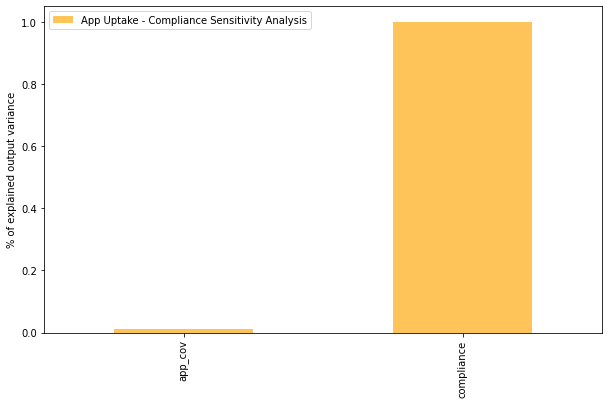

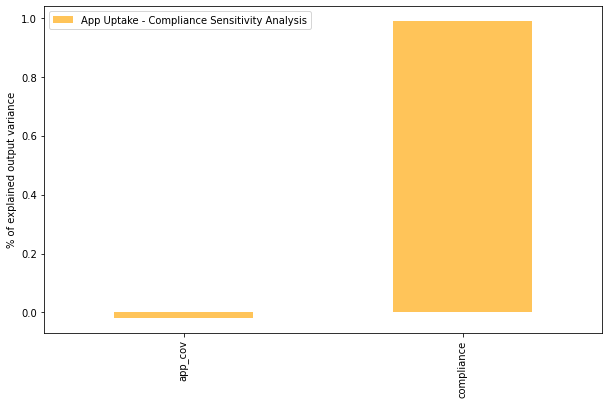

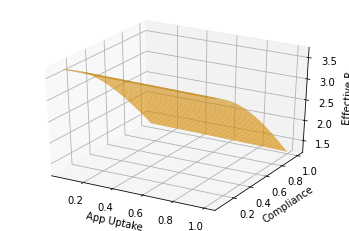

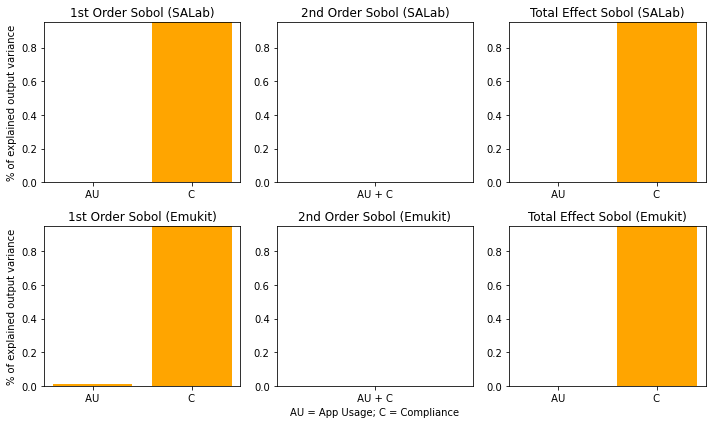

In [111]:
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", s_levels[0])[s_levels[0]]
factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
strategy_config['do_manual_tracing']  = False
print(case_config)
print(contacts_config)
print(policy_config)
print(factor_config)
print(strategy_config)
rng = np.random.RandomState(42)

tti_model = TTIFlowModel(rng, **strategy_config)

run_sensitivity(s_levels[0], 50, 5, 100000, cols[2])



## S2 Test Based App Uptake Compliance Sensitivity Analysis


Optimization restart 1/1, f = -31.699336083904463
Optimization restart 1/1, f = -31.699336135187803


 /usr/local/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



Optimization restart 1/1, f = -32.92787541637415



Optimization restart 1/1, f = -34.18243395876215



Optimization restart 1/1, f = -35.409402084744194



Optimization restart 1/1, f = -36.0140507023846



Optimization restart 1/1, f = -37.16076558151882



Optimization restart 1/1, f = -38.42788818962805



Optimization restart 1/1, f = -39.1048248906211



Optimization restart 1/1, f = -40.1065602233148



Optimization restart 1/1, f = -41.12771409285689



Optimization restart 1/1, f = -42.45431011259046
main_effects:  {'app_cov': array([0.03066486]), 'compliance': array([1.0003973])}
total_effects:  {'app_cov': array([-0.07248684]), 'compliance': array([0.96933514])}
(100, 100)
(100, 100)


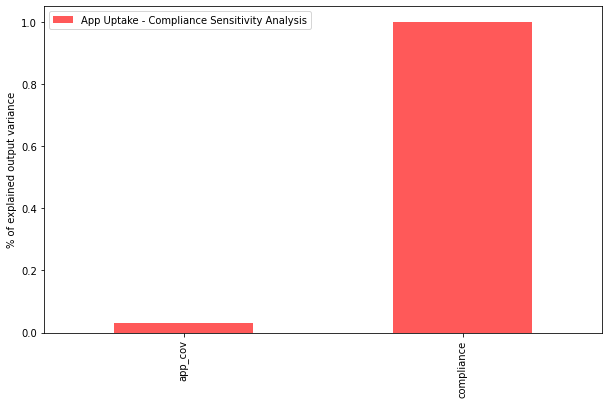

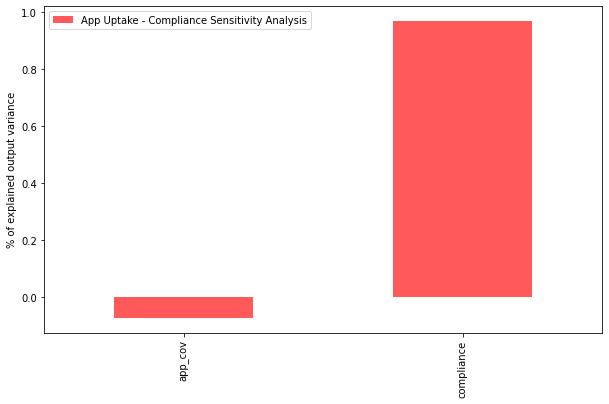

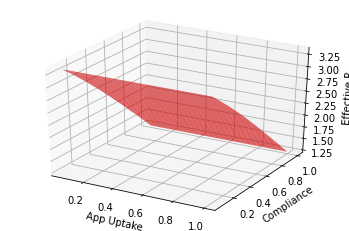

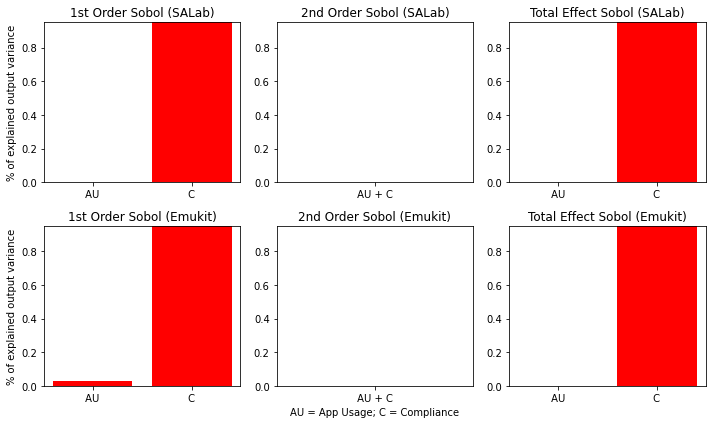

In [113]:
strigency = s_levels[1]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", s_levels[1])[strigency]
factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
rng = np.random.RandomState(42)

tti_model = TTIFlowModel(rng, **strategy_config)

run_sensitivity(strigency, 50, 10, 100000, cols[0])



## S3 Test Based App Uptake Compliance Sensitivity Analysis

In [ ]:
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", s_levels[2])[strigency]
factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
rng = np.random.RandomState(42)

tti_model = TTIFlowModel(rng, **strategy_config)

run_sensitivity(strigency, 50, 10, 100000, cols[2])

## S4 Test Based App Uptake Compliance Sensitivity Analysis


Optimization restart 1/1, f = -61.976413611165455
Optimization restart 1/1, f = -61.97641362380515


 /usr/local/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



Optimization restart 1/1, f = -61.7131353569771



Optimization restart 1/1, f = -62.80690094516006



Optimization restart 1/1, f = -64.4041368642368



Optimization restart 1/1, f = -65.73726500622169



Optimization restart 1/1, f = -65.78638129742569



Optimization restart 1/1, f = -67.58574760863985



Optimization restart 1/1, f = -68.73582475826274



Optimization restart 1/1, f = -70.25652386465345



Optimization restart 1/1, f = -72.07463290412366



Optimization restart 1/1, f = -73.0464446428859
main_effects:  {'app_cov': array([-0.01023212]), 'compliance': array([1.00034549])}
total_effects:  {'app_cov': array([0.01569855]), 'compliance': array([1.01023207])}
(100, 100)
(100, 100)


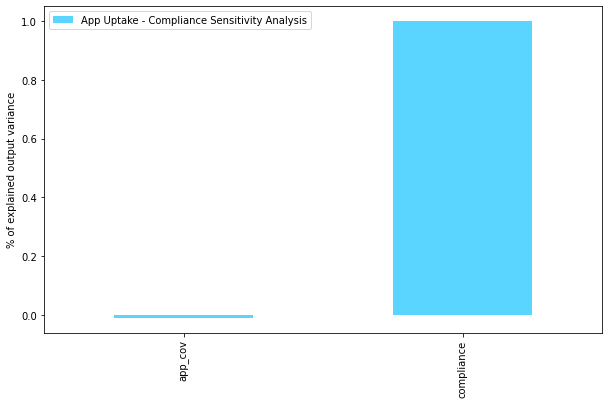

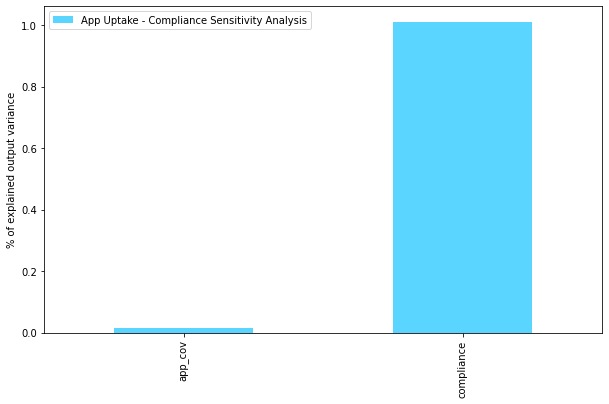

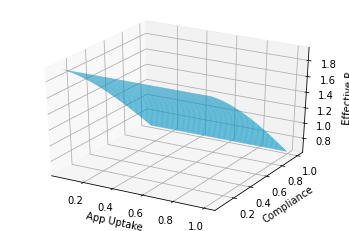

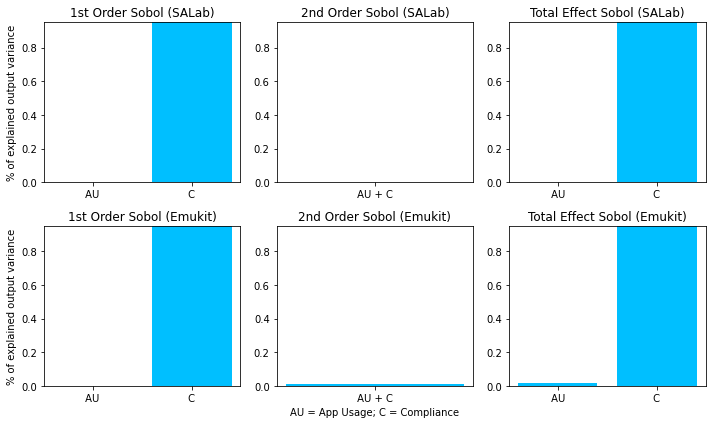

In [114]:
strigency = s_levels[3]


case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", s_levels[3])[strigency]
factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
rng = np.random.RandomState(42)

tti_model = TTIFlowModel(rng, **strategy_config)

run_sensitivity(strigency, 50, 10, 100000, cols[3])



## S5 Test Based App Uptake Compliance Sensitivity Analysis


Optimization restart 1/1, f = -66.68160112125905
Optimization restart 1/1, f = -66.68160112126293


 /usr/local/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



Optimization restart 1/1, f = -68.28542508833095



Optimization restart 1/1, f = -69.12819033920623



Optimization restart 1/1, f = -69.95988596872287



Optimization restart 1/1, f = -71.4567086065176



Optimization restart 1/1, f = -71.64582489726844



Optimization restart 1/1, f = -73.55574970379686



Optimization restart 1/1, f = -74.05859516394638



Optimization restart 1/1, f = -75.49032021926831



Optimization restart 1/1, f = -76.86342523725324



Optimization restart 1/1, f = -77.87686962185377
main_effects:  {'app_cov': array([-0.01127196]), 'compliance': array([1.00033272])}
total_effects:  {'app_cov': array([0.03258334]), 'compliance': array([1.01127198])}
(100, 100)
(100, 100)


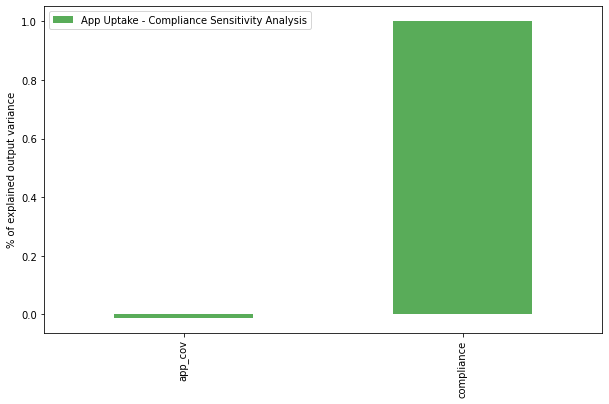

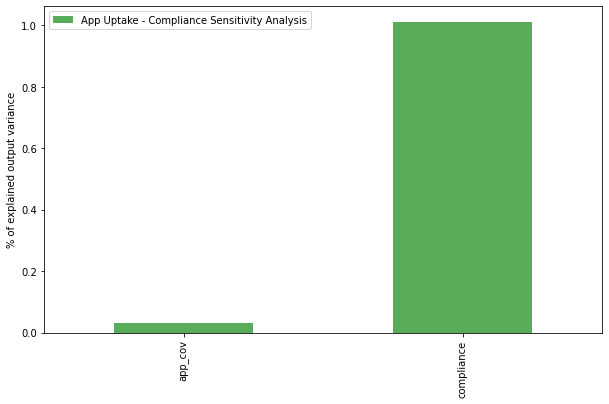

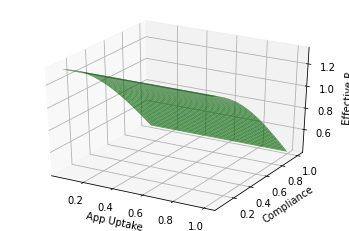

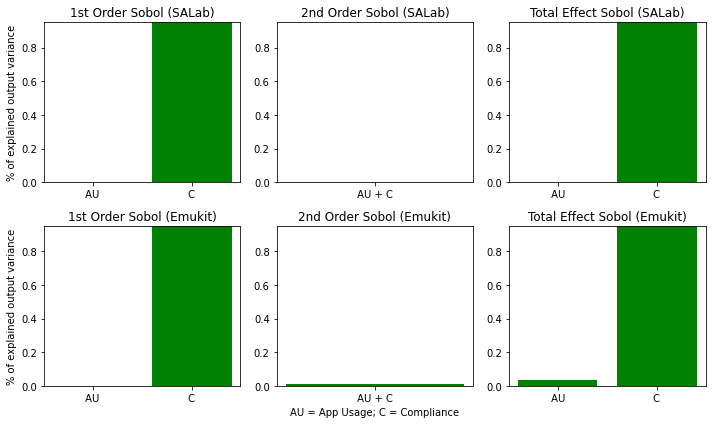

In [116]:
strigency = s_levels[4]


case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", s_levels[4])[strigency]
factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
rng = np.random.RandomState(42)

tti_model = TTIFlowModel(rng, **strategy_config)

run_sensitivity(strigency, 50, 10, 100000, cols[4])

